# Making Features and a Validation Set

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

%matplotlib inline

In [2]:
from elo_helpers import *

In [3]:
train = pd.read_csv('data/train.csv', dtype=train_dtypes)
test = pd.read_csv('data/test.csv', dtype=test_dtypes).fillna('2017-03')

In [4]:
merch = pd.read_csv('data/merchants.csv', dtype=merch_dtypes)
hist_trans = pd.read_csv('data/historical_transactions.csv', dtype=trans_dtypes)
new_trans = pd.read_csv('data/new_merchant_transactions.csv', dtype=trans_dtypes)

In [5]:
for cols in ['category_1', 'category_4', 'most_recent_purchases_range', 'most_recent_sales_range']:
    merch[cols] = merch[cols].astype('category')

### Validation Set

Looks like we can just make it randomly. Need to do more feature engineering before this is possible. Need to drop `card_id` and `target` from X set for validation. Using `test_size=0.35` and `random_state=11`.

### Feature Engineering

In [6]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [6]:
reg_target_encoding(train, 'feature_1', 'target', 'mean')
reg_target_encoding(train, 'feature_2', 'target', 'mean')
reg_target_encoding(train, 'feature_3', 'target', 'mean')

train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,feature_1_mean_enc,feature_2_mean_enc,feature_3_mean_enc
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,-0.501972,-0.342233,-0.429176
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,-0.377079,-0.389225,-0.349962
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,-0.349808,-0.342233,-0.349962
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,-0.377079,-0.512248,-0.349962
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,-0.305659,-0.512248,-0.349962


In [7]:
train_v2 = pd.get_dummies(train, columns=['feature_1', 'feature_2', 'feature_3'])

In [14]:
%%timeit
train_v2.first_active_month.str.split('-')[0]
train_v2.first_active_month.str.split('-')[1]

234 ms ± 5.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit
pd.to_datetime(train_v2.first_active_month).dt.month
pd.to_datetime(train_v2.first_active_month).dt.year

96.2 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
# turn these into categories?
train_v2['elapsed_time'] = (pd.to_datetime(train_v2.first_active_month.max()).date() - pd.to_datetime(train_v2.first_active_month).dt.date).dt.days
train_v2['first_active_year'] = pd.to_datetime(train_v2.first_active_month).dt.year
train_v2['first_active_month'] = pd.to_datetime(train_v2.first_active_month).dt.month

# do time elapsed from first active date to present date
# df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days

In [66]:
pd.to_datetime(train.first_active_month.max()).date()

datetime.date(2018, 2, 1)

In [19]:
column_match(train, hist_trans)

array(['card_id'], dtype=object)

In [18]:
column_match(hist_trans, merch)

array(['city_id', 'category_1', 'merchant_category_id', 'merchant_id',
       'category_2', 'state_id', 'subsector_id'], dtype=object)

Tackle `hist_trans` first.

In [13]:
hist_trans.isna().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

In [22]:
hist_trans.head(3).transpose()

,0,1,2
authorized_flag,Y,Y,Y
card_id,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc
city_id,88,88,88
category_1,N,N,N
installments,0,0,0
category_3,A,A,A
merchant_category_id,80,367,80
merchant_id,M_ID_e020e9b302,M_ID_86ec983688,M_ID_979ed661fc
month_lag,-8,-7,-6
purchase_amount,-0.703331,-0.733128,-0.720386


In [23]:
hist_trans.merchant_id.nunique()

326311

In [24]:
hist_trans.authorized_flag.unique()

array(['Y', 'N'], dtype=object)

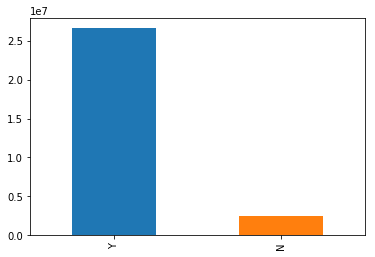

In [70]:
hist_trans.authorized_flag.value_counts().plot(kind='bar')

In [11]:
# categorical or label encode as 0s and 1s?
# for both category 1 and authorized flag
hist_trans.category_1.astype('category').head()

0    N
1    N
2    N
3    N
4    N
Name: category_1, dtype: category
Categories (2, object): [N, Y]

In [57]:
pd.DatetimeIndex(hist_trans['purchase_date'].head()).\
                                      astype(np.int64) * 1e-9

Float64Index([1498404787.0, 1500120645.0, 1502316269.0, 1504346786.0,
              1489108459.0],
             dtype='float64', name='purchase_date')

In [58]:
hist_trans.purchase_date.head()

0    2017-06-25 15:33:07
1    2017-07-15 12:10:45
2    2017-08-09 22:04:29
3    2017-09-02 10:06:26
4    2017-03-10 01:14:19
Name: purchase_date, dtype: object

In [59]:
pd.DatetimeIndex(hist_trans['purchase_date'].head())

DatetimeIndex(['2017-06-25 15:33:07', '2017-07-15 12:10:45',
               '2017-08-09 22:04:29', '2017-09-02 10:06:26',
               '2017-03-10 01:14:19'],
              dtype='datetime64[ns]', name='purchase_date', freq=None)

In [14]:
hist_trans.category_3.unique()

array(['A', 'B', 'C', nan], dtype=object)

In [9]:
# do time of day?
# do time elapsed since purchase and between purchase and start date
hist_trans['purchase_date_year'] = pd.to_datetime(hist_trans.purchase_date).dt.year
hist_trans['purchase_date_month'] = pd.to_datetime(hist_trans.purchase_date).dt.month
hist_trans['purchase_date_day'] = pd.to_datetime(hist_trans.purchase_date).dt.day

hist_trans['purchase_date_hour'] = pd.to_datetime(hist_trans.purchase_date).dt.hour

In [10]:
hist_trans['authorized_flag'] = hist_trans['authorized_flag'].map({'Y':1, 'N':0})

In [81]:
hist_trans.authorized_flag.mean()

0.9135450058482031

In [22]:
hist_trans.city_id.nunique(), hist_trans.state_id.nunique()

(308, 25)

In [30]:
hist_trans.subsector_id.nunique(), merch.subsector_id.nunique()

(41, 41)

What to do (target) encoding on? 

#### Merchant Dataset

In [26]:
merch.head(3).transpose()

,0,1,2
merchant_id,M_ID_838061e48c,M_ID_9339d880ad,M_ID_e726bbae1e
merchant_group_id,8353,3184,447
merchant_category_id,792,840,690
subsector_id,9,20,1
numerical_1,-0.0574706,-0.0574706,-0.0574706
numerical_2,-0.0574706,-0.0574706,-0.0574706
category_1,N,N,N
most_recent_sales_range,E,E,E
most_recent_purchases_range,E,E,E
avg_sales_lag3,-0.4,-0.72,-82.13


In [33]:
# Why are these the same?
np.all(merch.numerical_1) == np.all(merch.numerical_2)

True

In [34]:
# can we deduce the sales range amounts?
merch.most_recent_purchases_range.unique()

[E, D, C, A, B]
Categories (5, object): [E, D, C, A, B]

In [28]:
merch.most_recent_sales_range.unique()

[E, C, D, A, B]
Categories (5, object): [E, C, D, A, B]

In [31]:
merch.merchant_category_id.nunique(), merch.merchant_group_id.nunique()

(324, 109391)

### Slightly More Advanced Models

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [14]:
lr = LinearRegression(normalize=False)

X = train_v2.drop(['card_id', 'target'], axis=1)
y = train_v2.target

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size = 0.35, random_state=11)

lr.fit(X_tr, y_tr)

val_preds = lr.predict(X_val)

calc_rmse(y_val, val_preds)

3.8294417623804233

In [11]:
mean_encoding_test(test, train, 'feature_1', 'target')
mean_encoding_test(test, train, 'feature_2', 'target')
mean_encoding_test(test, train, 'feature_3', 'target')

In [12]:
test_v2 = pd.get_dummies(test, columns=['feature_1', 'feature_2', 'feature_3'])
test_v2['elapsed_time'] = (pd.to_datetime(test_v2.first_active_month.max()).date() - pd.to_datetime(test_v2.first_active_month).dt.date).dt.days
test_v2['first_active_year'] = pd.to_datetime(test_v2.first_active_month).dt.year
test_v2['first_active_month'] = pd.to_datetime(test_v2.first_active_month).dt.month

In [15]:
test_preds = lr.predict(test_v2.drop(['card_id'], axis=1))
base_sub_df = pd.DataFrame(np.array([test.card_id, test_preds]).T, columns=['card_id', 'target'])

base_sub_df.to_csv('submissions/sub_3_baseline_feng.csv', index=False)

#### How about a RF Model?

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
rfr = RandomForestRegressor(n_estimators=100, oob_score=True)

rfr.fit(X_tr, y_tr)

val_preds_rfr = rfr.predict(X_val)

calc_rmse(y_val, val_preds_rfr)

3.8606348026228456

No improvement on the leaderboard

In [20]:
test_preds_rfr = rfr.predict(test_v2.drop(['card_id'], axis=1))
base_sub_rfr_df = pd.DataFrame(np.array([test.card_id, test_preds_rfr]).T, columns=['card_id', 'target'])

base_sub_rfr_df.to_csv('submissions/sub_4_rfr_base_feng.csv', index=False)

### Back to FEng

In [14]:
column_match(train_v2, hist_trans)

array(['card_id'], dtype=object)

In [21]:
train_v3 = train_v2.merge(hist_trans, how='left', on='card_id')

In [26]:
ht_agg = aggregate_historical_transactions(hist_trans)

In [28]:
new_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [29]:
new_trans['purchase_date_year'] = pd.to_datetime(new_trans.purchase_date).dt.year
new_trans['purchase_date_month'] = pd.to_datetime(new_trans.purchase_date).dt.month
new_trans['purchase_date_day'] = pd.to_datetime(new_trans.purchase_date).dt.day

new_trans['purchase_date_hour'] = pd.to_datetime(new_trans.purchase_date).dt.hour

new_trans['authorized_flag'] = new_trans['authorized_flag'].map({'Y':1, 'N':0})

In [31]:
nt_agg.head()

,card_id,new_transactions_count,new_authorized_flag_sum,new_authorized_flag_mean,new_merchant_id_nunique,new_city_id_nunique,new_purchase_amount_sum,new_purchase_amount_median,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_median,new_installments_max,new_installments_min,new_installments_std,new_month_lag_min,new_month_lag_max
0,C_ID_00007093c1,2,2,1,2,2,-1.328524,-0.664262,-0.656749,-0.671775,0.010625,2,1.0,1,1,0.000000,2,2
1,C_ID_0001238066,26,26,1,25,8,-14.850055,-0.649235,-0.078318,-0.740897,0.173436,42,1.0,10,-1,2.079941,1,2
2,C_ID_0001506ef0,2,2,1,1,1,-1.447354,-0.723677,-0.715352,-0.732001,0.011773,0,0.0,0,0,0.000000,1,1
3,C_ID_0001793786,31,31,1,31,7,-0.229620,-0.372748,3.129932,-0.737892,0.947223,0,0.0,0,0,0.000000,1,2
4,C_ID_000183fdda,11,11,1,11,2,-6.590778,-0.665765,-0.107680,-0.732332,0.182877,16,1.0,4,-1,1.293340,1,2


In [30]:
nt_agg = aggregate_new_transactions(new_trans)

In [33]:
train_v3 = train_v2.merge(ht_agg, how='left', on='card_id')
test_v3 = test_v2.merge(ht_agg, how='left', on='card_id')

In [34]:
train_v4 = train_v3.merge(nt_agg, how='left', on='card_id')
test_v4 = test_v3.merge(nt_agg, how='left', on='card_id')

In [25]:
hg = hist_trans.groupby('card_id')

hg.authorized_flag.aggregate(['sum', 'mean']).reset_index().head()

In [41]:
train_v4.to_feather('./data/train_v4.feather')
test_v4.to_feather('./data/test_v4.feather')

In [31]:
train_v3.head(3).transpose()

,0,1,2
first_active_month,6,6,6
card_id,C_ID_92a2005557,C_ID_92a2005557,C_ID_92a2005557
target,-0.820283,-0.820283,-0.820283
feature_1_mean_enc,-0.501972,-0.501972,-0.501972
feature_2_mean_enc,-0.342233,-0.342233,-0.342233
feature_3_mean_enc,-0.429176,-0.429176,-0.429176
feature_1_1,0,0,0
feature_1_2,0,0,0
feature_1_3,0,0,0
feature_1_4,0,0,0


In [ ]:
reg_target_encoding(train_v3, 'authorized_flag', 'target', 'mean')

reg_target_encoding(train_v3, 'category_1', 'target', 'mean')
reg_target_encoding(train_v3, 'category_2', 'target', 'mean')
reg_target_encoding(train_v3, 'category_3', 'target', 'mean')

reg_target_encoding(train_v3, 'first_active_year', 'target', 'mean')
reg_target_encoding(train_v3, 'first_active_month', 'target', 'mean')
reg_target_encoding(train_v3, 'city_id', 'target', 'mean')

reg_target_encoding(train_v3, 'merchant_category_id', 'target', 'mean')
reg_target_encoding(train_v3, 'merchant_id', 'target', 'mean')

reg_target_encoding(train_v3, 'state_id', 'target', 'mean')
reg_target_encoding(train_v3, 'subsector_id', 'target', 'mean')

In [ ]:
print('hello this is done!!! you should save this csv!!!')
print()
print('no really save this csv')